# Game block

In [ ]:
import pygame
import random
import numpy as np
import os

# Define colors
BLACK = (0, 0, 0)
WHITE = (255, 255, 255)
GRAY = (170, 170, 170)
ORANGE = (255, 128, 0)
CAR_COLOR = (100, 65, 20)

# Initialize Pygame
pygame.init()

# Class representing the car
class Car:
    def __init__(self, x=0, y=0, dx=4, dy=0, width=30, height=30, color=ORANGE):
        self.image = None
        self.x = x
        self.y = y
        self.dx = dx
        self.dy = dy
        self.width = width
        self.height = height
        self.color = color
        
    # Try to load an image for the car    
    def load_image(self, img):
        if os.path.exists(img):
            try:
                self.image = pygame.image.load(img).convert()
                self.image.set_colorkey(BLACK)
            except pygame.error:
                self.image = None
        else:
            self.image = None 
    
    # Draw a rectangle as the car
    def draw_rect(self, screen):
        pygame.draw.rect(screen, self.color, [self.x, self.y, self.width, self.height], 0)

    # Draw the car: use image if available, otherwise draw a rectangle
    def draw(self, screen):
        if self.image:
            self.draw_image(screen)
        else:
            self.draw_rect(screen)   

    def draw_image(self, screen):
        screen.blit(self.image, [self.x, self.y])

    def move_x(self):
        self.x += self.dx

    def move_y(self):
        self.y += self.dy

    # Check if the car is out of screen bounds and adjust position
    def check_out_of_screen(self):
        if self.x + self.width > 400 or self.x < 0:
            self.x -= self.dx

# Main game class
class CarGameAI:
    def __init__(self):
        self.size = (400, 700)
        self.screen = pygame.display.set_mode(self.size)
        pygame.display.set_caption("Ride the Road")
        self.clock = pygame.time.Clock()  # Control game framerate
        self.font_30 = pygame.font.SysFont("Arial", 30, True, False)
        self.reward = 0
        self.reset()

    def reset(self):
        self.player = Car(165, 570, 0, 0, 70, 130, ORANGE) # Create the player's car
        self.player.load_image("player.png")
        self.score = 0
        self.car = Car(random.randrange(0, 340), random.randrange(-150, -50), 0, 4, 60, 60, CAR_COLOR) # Create the obstacle car 
        self.game_over = False

    # Update the obstacle car's position
    def update_car(self):
        self.car.draw_rect(self.screen)
        self.car.move_y()
        if self.car.y > self.size[1]: # If the car is off the screen
            self.score += 10
            self.reward = 20  # Main reward
            self.car.y = random.randrange(-150, -50)
            self.car.x = random.randrange(0, 340)
            self.car.dy = 4

    def check_collision(self):
        if (
            self.player.x + self.player.width > self.car.x
            and self.player.x < self.car.x + self.car.width
            and self.player.y < self.car.y + self.car.height
            and self.player.y + self.player.height > self.car.y
            ):
            return True # Collision detected
        return False

    # Main game loop
    def play_step(self, action):
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()
                quit()
    
        # Process actions: left, right, or stay    
        if np.array_equal(action, [1, 0, 0]): # Move left
            self.player.dx = -4
            if self.car.x + self.car.width >= 399 - self.player.width and self.player.x + self.player.width >= self.car.x:
                self.reward = 10  # Reward for safe movement
            if self.player.x <= 3:  # If player is too far left
                  self.reward += -2

        elif np.array_equal(action, [0, 1, 0]): # Move right
            self.player.dx = 4
            if self.car.x <= 1 + self.player.width and self.player.x <= self.car.x + self.car.width:
                self.reward = 10  # Reward for safe movement
            if self.player.x + self.player.width >= 397:  # If player is too far right
                self.reward += -2
                            
        else: # No movement
            self.player.dx = 0
            if self.car.x + self.car.width > self.player.x and self.car.x < self.player.x+self.player.width:
                self.reward = -10  # Penalty for being in danger zone
            else: 
                self.reward = 10  # Reward for staying safe

        # Update game display and state
        self.screen.fill(GRAY)
        self.player.draw(self.screen)
        self.player.move_x()
        self.player.check_out_of_screen()
        self.update_car()

        # Check for collisions
        if self.check_collision():
            self.game_over = True
            self.reward = -20  # Main penalty
            return self.reward, self.game_over, self.score

        # Display the score on the screen
        txt_score = self.font_30.render("Score: " + str(self.score), True, WHITE)
        self.screen.blit(txt_score, [15, 15])

        pygame.display.flip() # Update display
        self.clock.tick(400) # Limit game speed
        return self.reward, self.game_over, self.score

# Model block

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os

# Neural Network Model for Q-learning
class Linear_QNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

    # Save the model's parameters to a file
    def save(self, file_name='model.pth'):
        model_folder_path = './model'
        if not os.path.exists(model_folder_path):
            os.makedirs(model_folder_path)

        file_name = os.path.join(model_folder_path, file_name)
        torch.save(self.state_dict(), file_name)

# Trainer class for Q-learning
class QTrainer:
    def __init__(self, model, lr, gamma):
        self.lr = lr
        self.gamma = gamma  # Discount factor
        self.model = model
        self.optimizer = optim.Adam(model.parameters(), lr=self.lr)
        self.criterion = nn.MSELoss()

    def train_step(self, state, action, reward, next_state, done):
        state = torch.tensor(state, dtype=torch.float)
        next_state = torch.tensor(next_state, dtype=torch.float)
        action = torch.tensor(action, dtype=torch.long)
        reward = torch.tensor(reward, dtype=torch.float)

        # Ensure the input has the correct dimensions
        if len(state.shape) == 1:  # (1, x)
            state = torch.unsqueeze(state, 0)
            next_state = torch.unsqueeze(next_state, 0)
            action = torch.unsqueeze(action, 0)
            reward = torch.unsqueeze(reward, 0)
            done = (done,)

        # Predicted Q values with the current state
        pred = self.model(state)

        # Clone the predictions and modify only the Q value for the selected action
        target = pred.clone()
        for idx in range(len(done)):
            Q_new = reward[idx]
            if not done[idx]:
                # Update Q value based on Bellman equation
                Q_new = reward[idx] + self.gamma * torch.max(self.model(next_state[idx]))
            
            target[idx][torch.argmax(action[idx]).item()] = Q_new

        # Perform backpropagation
        self.optimizer.zero_grad()
        loss = self.criterion(target, pred)
        loss.backward()
        self.optimizer.step()

# Plot block

In [7]:
import matplotlib.pyplot as plt
from IPython import display

plt.ion()

# Plot training results (scores)
def plot(scores, mean_scores):
    display.clear_output(wait=True)
    display.display(plt.gcf())
    plt.clf()
    plt.title('Training...')
    plt.xlabel('Number of Games')
    plt.ylabel('Score')
    plt.plot(scores)
    plt.plot(mean_scores)
    plt.ylim(ymin=0)
    plt.text(len(scores) - 1, scores[-1], str(scores[-1]))
    plt.text(len(mean_scores) - 1, mean_scores[-1], str(mean_scores[-1]))
    plt.show(block=False)
    plt.pause(.1) # Pause for a short time to update the plot

# Agent (main) block

<Figure size 640x480 with 0 Axes>

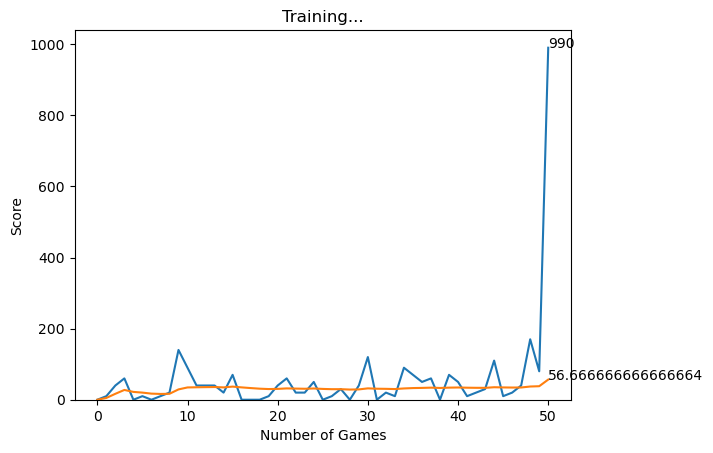

KeyboardInterrupt: 

In [8]:
import torch
import random
import numpy as np
from collections import deque

MAX_MEMORY = 100_000 # Maximum memory size for replay buffer
BATCH_SIZE = 500
LR = 0.001

# Agent class responsible for interacting with the environment
class Agent:

    def __init__(self):
        self.n_games = 0
        self.epsilon = 0  # Exploration rate (for epsilon-greedy strategy)
        self.gamma = 0.9  # Discount factor
        self.memory = deque(maxlen=MAX_MEMORY) # Experience replay memory
        self.model = Linear_QNet(9, 100, 3)
        self.trainer = QTrainer(self.model, lr=LR, gamma=self.gamma)

    # Get the current state of the game
    def get_state(self, game):
        state = [0, 0, 0, 0, 0, 0, 0, 0, 0]
        if game.car.x > game.player.x + game.player.width: # Car is to the right of player
            state[0] = 1
        if game.car.x + game.car.width < game.player.x: # Car is to the left of player
            state[1] = 1
        if game.player.x < 4: # Player is too far left
            state[2] = 1
        if game.player.x + game.player.width > 396: # Player is too far right
            state[3] = 1              
        if game.car.x + game.car.width >= 399 - game.player.width: # Not enough space on the right
            state[4] = 1
        if game.car.x + game.car.width >= 399 - game.player.width and game.player.x + game.player.width >= game.car.x:
            state[5] = 1
        if game.car.x <= 1 + game.player.width:  # Not enough space on the left
            state[6] = 1
        if game.car.x <= 1 + game.player.width and game.player.x <= game.car.x + game.car.width:
            state[7] = 1
        if game.car.x + game.car.width > game.player.x and game.car.x < game.player.x+game.player.width:
            state[8] = 1  # Potential collision
        return state

    # Store the experience in the replay memory
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    # Train using a batch of experiences from the memory (long-term memory)
    def train_long_memory(self):
        if len(self.memory) > BATCH_SIZE:
            mini_sample = random.sample(self.memory, BATCH_SIZE)
        else:
            mini_sample = self.memory

        states, actions, rewards, next_states, dones = zip(*mini_sample)
        self.trainer.train_step(states, actions, rewards, next_states, dones)

    # Train using the most recent experience (short-term memory)
    def train_short_memory(self, state, action, reward, next_state, done):
        self.trainer.train_step(state, action, reward, next_state, done)

    # Get the action for the current state using epsilon-greedy policy
    def get_action(self, state):
        self.epsilon = 50 - self.n_games  # Decrease exploration over time
        final_move = [0, 0, 0]
        if random.randint(0, 50) < self.epsilon: # Random action (exploration)
            move = random.randint(0, 2)
            final_move[move] = 1
        else:
            state0 = torch.tensor(state, dtype=torch.float)
            prediction = self.model(state0) # Predict the action values
            move = torch.argmax(prediction).item() # Choose the action with highest Q value
            final_move[move] = 1

        return final_move

# Train the agent
def train():
    plot_scores = []
    plot_mean_scores = []
    total_score = 0
    record = 0
    agent = Agent()
    game = CarGameAI()
    while True:
        state_old = agent.get_state(game)  # Get the current state of the game
        final_move = agent.get_action(state_old)  # Get move

        # Perform move and get new state
        reward, done, score = game.play_step(final_move)
        state_new = agent.get_state(game)

        agent.train_short_memory(state_old, final_move, reward, state_new, done)
        agent.remember(state_old, final_move, reward, state_new, done)
        
        # If the game is over
        if done:  
            game.reset()
            agent.n_games += 1
            agent.train_long_memory()

            if score > record:
                record = score
                agent.model.save()
            
            # Plot result
            plot_scores.append(score)
            total_score += score
            mean_score = total_score / agent.n_games
            plot_mean_scores.append(mean_score)
            plot(plot_scores, plot_mean_scores)
            
        if agent.n_games > 200:
            break


if __name__ == '__main__':
    train()